In [1]:
import sys
sys.path.append("/home/amigos/seigyo/analy/shiotani/git/analy_n2data/")
import necstdb
import math
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import n2analy
import xarray as xr
from datetime import datetime
import numpy as np
from scipy.optimize import curve_fit

In [2]:
! pwd

/home/amigos/seigyo/analy/notebook_2020/Nishioka/Jupiter


In [3]:
path = '/mnt/usbdisk9/data/observation/otf_planet2018/n20200320150852_12CO_2-1_otfplanet_jupiter'

In [4]:
xFFTS_Data_topics = [
    
    'ac240_spectra_data_1',
    'ac240_spectra_data_2',
]

In [5]:
def get_array(path, xFFTS_Data_topics):
    db = necstdb.opendb(path)
    xFFTS_data = db.open_table('ac240_spectra_data_1').read(astype='array')
    obsmode =  db.open_table('obsmode').read(astype='array')
    enc =  db.open_table('status_encoder').read(astype='array')
    
    spec_array = xr.DataArray(

        xFFTS_data['spec'], 
        dims=['t', 'spectral_data'], 
        coords={'t':xFFTS_data['received_time']}
    )


    obsmode_array = xr.DataArray(

        obsmode['obs_mode'],
        dims = ['t'],
        coords={'t':obsmode['received_time'], 'scan_num':('t', obsmode['scan_num'])}


    )
    
    az_array = xr.DataArray(
        
        enc['enc_az']/3600, 
        dims=['t'],
        coords={'t':enc['timestamp']}
    )
    
    el_array = xr.DataArray(
        
        enc['enc_el']/3600, 
        dims=['t'],
        coords={'t':enc['timestamp']}
    )

    return spec_array, obsmode_array, az_array, el_array

def concatenate(spec_array, obsmode_array, az_array, el_array):
    
    reindexed_obsmode_array = obsmode_array.reindex(t=spec_array['t'], method='backfill')
    reindexed_encoder_az_array = az_array.interp_like(spec_array)
    reindexed_encoder_el_array = el_array.interp_like(spec_array)
    
    del obsmode_array
    del az_array
    del el_array
    raw_array = xr.DataArray(
        np.array(spec_array),
        dims=['t', 'spectral_data'],
        coords={'t':spec_array['t'],
                
               'obsmode':('t',np.array(reindexed_obsmode_array)),
               'scan_num':('t', np.array(reindexed_obsmode_array['scan_num'])),
               'azlist':('t', np.array(reindexed_encoder_az_array)),
               'ellist':('t', np.array(reindexed_encoder_el_array))
                
               }
    )
    
    return raw_array

def get_lb(raw_array, time, location):
    AltAzcoordiantes = astropy.coordinates.SkyCoord(
        
        az=raw_array['azlist'], 
        alt=raw_array['ellist'], 
        frame='altaz', 
        obstime=time,
        location=location, 
        unit='deg')
    
    l_list = AltAzcoordiantes.transform_to(Galactic).l
    b_list = AltAzcoordiantes.transform_to(Galactic).b
    return l_list, b_list

def make_data_array(raw_array, l_list, b_list, filename='hogehoge', save=False):
    data_array = xr.DataArray(
        np.array(raw_array), 
        dims=['t', 'spectral_data'],
        coords={'t':raw_array['t'],
               'obsmode':('t',np.array(raw_array['obsmode'])),
               'scan_num':('t', np.array(raw_array['scan_num'])),
               'l_list':('t', l_list),
               'b_list':('t', b_list)}
    )
    
    if save == True:
        data_array.to_netcdf(f"/mnt/usbdisk10/analy_n2data/OTF_netcdf/{filename}.cdf")
    return data_array

In [6]:
spec_array, obsmode_array, az_array, el_array = get_array(path, xFFTS_Data_topics[0])
raw_array = concatenate(spec_array, obsmode_array, az_array, el_array)

In [7]:
ON_OL = raw_array['obsmode'] == b'ON        '
ON = raw_array[ON_OL]
ON_TP = np.sum(ON,axis=1)

In [8]:
ON_TP_list = []
for i in range(31):
    ON_tpi = ON_TP['scan_num'] == i
    ON_TPi = ON_TP[ON_tpi]
    ON_TP_list.append(ON_TPi)

In [9]:
ON_TP_list

[<xarray.DataArray (t: 239)>
 array([2.2737805e+11, 2.2789667e+11, 2.2981847e+11, 2.2852272e+11,
        2.3019130e+11, 2.3080210e+11, 2.3048067e+11, 2.2982096e+11,
        2.2973084e+11, 2.3023252e+11, 2.2964532e+11, 2.2939222e+11,
        2.2918323e+11, 2.2896606e+11, 2.2874200e+11, 2.2849800e+11,
        2.2829498e+11, 2.2826906e+11, 2.2805106e+11, 2.2840761e+11,
        2.2821816e+11, 2.2896981e+11, 2.3006002e+11, 2.3035686e+11,
        2.2840143e+11, 2.2783246e+11, 2.2775503e+11, 2.2701244e+11,
        2.2781693e+11, 2.2789390e+11, 2.2784029e+11, 2.2779858e+11,
        2.2778351e+11, 2.2739984e+11, 2.2843300e+11, 2.2828664e+11,
        2.2775664e+11, 2.2790811e+11, 2.2792090e+11, 2.2773760e+11,
        2.2748643e+11, 2.2734583e+11, 2.2733183e+11, 2.2821890e+11,
        2.2944819e+11, 2.2968436e+11, 2.2848420e+11, 2.2763356e+11,
        2.2743532e+11, 2.2728609e+11, 2.2752762e+11, 2.2757582e+11,
        2.2769713e+11, 2.2781677e+11, 2.2797866e+11, 2.2870462e+11,
        2.2936614e+

In [10]:
az_list = []
for i in range(len(ON_TP_list)):
    az = ON_TP_list[i]['azlist']
    az_list.append(az)

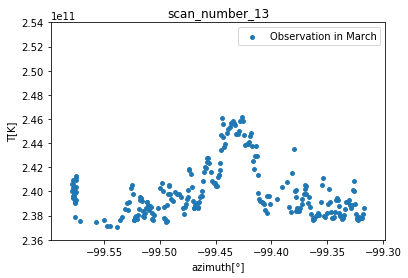

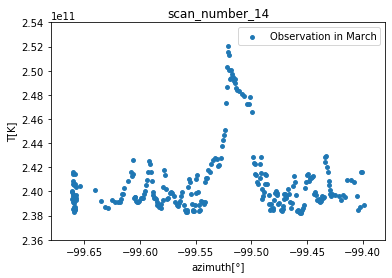

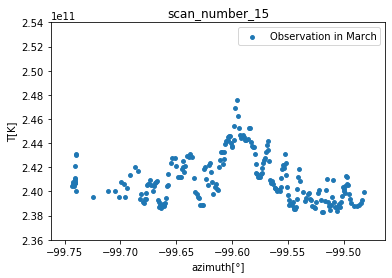

In [11]:
for i in range(3):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(az_list[i+13],ON_TP_list[i+13], s=15, label='Observation in March')
    ax.set_title('scan_number_' + f'{i+13}')
    ax.set_xlabel('azimuth[°]')
    ax.set_ylabel('T[K]')
    ax.set_ylim(2.36e11,2.54e11)
    ax.legend()
    #fig.savefig(f'/home/amigos/seigyo/analy/notebook_2020/Nishioka/per_az_2_1_ncw/az_T*_scan_number{i+13}.png')

In [12]:
import astropy
from astropy import coordinates as co
from astropy.time import Time

In [13]:
raw_array

<xarray.DataArray (t: 19070, spectral_data: 16384)>
array([[2.5314342e+08, 6.8934300e+05, 8.1699700e+05, ..., 1.4194623e+07,
        1.4443199e+07, 1.4134287e+07],
       [2.5537667e+08, 6.7463500e+05, 8.1831000e+05, ..., 1.4071308e+07,
        1.4307807e+07, 1.4092857e+07],
       [2.5550934e+08, 6.7498700e+05, 8.2677500e+05, ..., 1.3786558e+07,
        1.4515627e+07, 1.4474871e+07],
       ...,
       [2.8485062e+08, 6.7655400e+05, 8.3721300e+05, ..., 1.5419895e+07,
        1.5996406e+07, 1.5973173e+07],
       [2.8572109e+08, 6.8623100e+05, 8.1107300e+05, ..., 1.5823764e+07,
        1.6054698e+07, 1.5456632e+07],
       [2.8657197e+08, 6.7561600e+05, 8.3193500e+05, ..., 1.5747431e+07,
        1.5792518e+07, 1.5986799e+07]], dtype=float32)
Coordinates:
  * t         (t) float64 1.585e+09 1.585e+09 1.585e+09 ... 1.585e+09 1.585e+09
    obsmode   (t) |S12 b'Non       ' b'Non       ' ... b'Non       '
    scan_num  (t) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    azlist    (t) float64 48.79 48.79 48.79 48.79 ... -100.7 -100.7 -100.7
    ellist    (t) float64 55.08 55.08 55.08 55.08 ... 38.72 38.72 38.72 38.72
Dimensions without coordinates: spectral_data

In [14]:
from datetime import datetime

In [15]:
time_unix = raw_array['t']

In [16]:
time_unix

<xarray.DataArray 't' (t: 19070)>
array([1.584717e+09, 1.584717e+09, 1.584717e+09, ..., 1.584719e+09,
       1.584719e+09, 1.584719e+09])
Coordinates:
  * t         (t) float64 1.585e+09 1.585e+09 1.585e+09 ... 1.585e+09 1.585e+09
    obsmode   (t) |S12 b'Non       ' b'Non       ' ... b'Non       '
    scan_num  (t) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    azlist    (t) float64 48.79 48.79 48.79 48.79 ... -100.7 -100.7 -100.7
    ellist    (t) float64 55.08 55.08 55.08 55.08 ... 38.72 38.72 38.72 38.72

In [17]:
time_gen = datetime.fromtimestamp(time_unix[0])

In [18]:
time_gen

datetime.datetime(2020, 3, 21, 0, 8, 52)

In [19]:
time_gen_list = []
for i in range(len(time_unix)):
    time_gen = datetime.fromtimestamp(time_unix[i])
    time_gen_list.append(time_gen)

In [20]:
time_gen_list

[datetime.datetime(2020, 3, 21, 0, 8, 52),
 datetime.datetime(2020, 3, 21, 0, 8, 53),
 datetime.datetime(2020, 3, 21, 0, 8, 53),
 datetime.datetime(2020, 3, 21, 0, 8, 53),
 datetime.datetime(2020, 3, 21, 0, 8, 53),
 datetime.datetime(2020, 3, 21, 0, 8, 54),
 datetime.datetime(2020, 3, 21, 0, 8, 54),
 datetime.datetime(2020, 3, 21, 0, 8, 54),
 datetime.datetime(2020, 3, 21, 0, 8, 54),
 datetime.datetime(2020, 3, 21, 0, 8, 55),
 datetime.datetime(2020, 3, 21, 0, 8, 55),
 datetime.datetime(2020, 3, 21, 0, 8, 55),
 datetime.datetime(2020, 3, 21, 0, 8, 55),
 datetime.datetime(2020, 3, 21, 0, 8, 56),
 datetime.datetime(2020, 3, 21, 0, 8, 56),
 datetime.datetime(2020, 3, 21, 0, 8, 56),
 datetime.datetime(2020, 3, 21, 0, 8, 56),
 datetime.datetime(2020, 3, 21, 0, 8, 57),
 datetime.datetime(2020, 3, 21, 0, 8, 57),
 datetime.datetime(2020, 3, 21, 0, 8, 57),
 datetime.datetime(2020, 3, 21, 0, 8, 57),
 datetime.datetime(2020, 3, 21, 0, 8, 57),
 datetime.datetime(2020, 3, 21, 0, 8, 57),
 datetime.d

In [21]:
co.get_body('Jupiter', Time(time_gen_list[0]))

<SkyCoord (GCRS: obstime=2020-03-21 00:08:52, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    (294.42919029, -21.58231921, 5.48942621)>

In [22]:
co.get_body('Jupiter', Time(time_gen_list))

<SkyCoord (GCRS: obstime=[datetime.datetime(2020, 3, 21, 0, 8, 52)
 datetime.datetime(2020, 3, 21, 0, 8, 53)
 datetime.datetime(2020, 3, 21, 0, 8, 53) ...
 datetime.datetime(2020, 3, 21, 0, 50, 33)
 datetime.datetime(2020, 3, 21, 0, 50, 33)
 datetime.datetime(2020, 3, 21, 0, 50, 33)], obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    [(294.42919029, -21.58231921, 5.48942621),
     (294.42919212, -21.58231894, 5.48942603),
     (294.42919212, -21.58231894, 5.48942603), ...,
     (294.43376401, -21.58166585, 5.48899419),
     (294.43376401, -21.58166585, 5.48899419),
     (294.43376401, -21.58166585, 5.48899419)]>